In [2]:
# Sri lankan Job Market Analysis

# ===================================================
# SETUP & DATA LOADING
# ===================================================

# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Make plots appear in notebook
%matplotlib inline

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [5]:
# ===============================================
# Load row data
# ===============================================

print("\n" + "="*70)
print("LOADING RAW DATA")
print("="*70)


# Load data - ADJUST PATHS IF NEEDED
jobs_raw = pd.read_csv('../data/raw/srilanka_job_market_data.csv')
revenue_raw = pd.read_csv('../data/raw/srilanka_recruitment_revenue_data.csv')
skills_raw = pd.read_csv('../data/raw/srilanka_skills_demand_data.csv')

print(f"Jobs data loaded: {len(jobs_raw)} records")
print(f"Revenue data loaded: {len(revenue_raw)} records")
print(f"Skills data loaded: {len(skills_raw)} records")

# Display initial data preview
print("\nRAW DATA PREVIEW:")
print("\nJobs Data (first 3 rows):")
print(jobs_raw.head(3))
print("\nRevenue Data (first 3 rows):")
print(revenue_raw.head(3))
print("\nSkills Data (first 3 rows):")
print(skills_raw.head(3))


LOADING RAW DATA
Jobs data loaded: 600 records
Revenue data loaded: 36 records
Skills data loaded: 540 records

RAW DATA PREVIEW:

Jobs Data (first 3 rows):
    Job_ID   Post_Date     Industry          Job_Role    Location  \
0  JOB0472  2022-01-01  IT/Software       QA Engineer      Jaffna   
1  JOB0022  2022-01-05   E-commerce    Content Writer     Colombo   
2  JOB0566  2022-01-07   E-commerce  Graphic Designer  Kurunegala   

                                     Required_Skills  Experience_Years  \
0       API Testing, Test Automation, Manual Testing                 4   
1  Research, SEO Writing, WordPress, Content Writing                 4   
2  Adobe Photoshop, InDesign, Illustrator, Creati...                 6   

   Salary_LKR   Job_Type Remote_Option  Applications_Received  \
0       81721  Freelance            No                     90   
1       74890  Full-time           Yes                    198   
2       89692  Full-time        Hybrid                    175   

   Time

In [6]:
# ============================================================================
# DATA QUALITY CHECKING
# ============================================================================

print("\n" + "="*70)
print("DATA QUALITY CHECKING")
print("="*70)

def assess_data_quality(df, dataset_name):
    """Assess and report data quality issues"""
    print(f"\n {dataset_name} Quality Report:")
    print("-" * 60)
    
    #  Shape
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    
    #  Data types
    print(f"\nData Types:")
    print(df.dtypes)
    
    #  Missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n Missing Values Found:")
        print(missing[missing > 0])
    else:
        print(f"\n No missing values")
    
    # 4. Duplicates
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"\n Duplicate rows: {duplicates}")
    else:
        print(f" No duplicate rows")
    
    #  Memory usage
    print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
    
    return missing, duplicates

# Assess each dataset
jobs_missing, jobs_dup = assess_data_quality(jobs_raw, "JOB MARKET DATA")
revenue_missing, revenue_dup = assess_data_quality(revenue_raw, "REVENUE DATA")
skills_missing, skills_dup = assess_data_quality(skills_raw, "SKILLS DATA")



DATA QUALITY CHECKING

 JOB MARKET DATA Quality Report:
------------------------------------------------------------
Shape: 600 rows × 15 columns

Data Types:
Job_ID                   object
Post_Date                object
Industry                 object
Job_Role                 object
Location                 object
Required_Skills          object
Experience_Years          int64
Salary_LKR                int64
Job_Type                 object
Remote_Option            object
Applications_Received     int64
Time_to_Fill_Days         int64
Year                      int64
Month                     int64
Quarter                  object
dtype: object

 No missing values
 No duplicate rows

Memory usage: 351.63 KB

 REVENUE DATA Quality Report:
------------------------------------------------------------
Shape: 36 rows × 25 columns

Data Types:
Date                      object
Year                       int64
Month                      int64
Month_Name                object
Quarter          

In [7]:
# ============================================================================
# DATA CLEANING & PREPROCESSING
# ============================================================================

print("\n" + "="*70)
print("DATA CLEANING & PREPROCESSING")
print("="*70)

# ============================================================================
# CLEAN JOB MARKET DATA
# ============================================================================

print("\nCleaning Job Market Data...")
jobs = jobs_raw.copy()  # Create working copy

# Convert date column to datetime
jobs['Post_Date'] = pd.to_datetime(jobs['Post_Date'], errors='coerce')
print(f"Converted Post_Date to datetime")

# Handle missing values
jobs_before_missing = jobs.isnull().sum().sum()
jobs = jobs.dropna(subset=['Post_Date', 'Job_ID', 'Industry', 'Job_Role'])  # Drop rows with critical missing data
jobs_after_missing = jobs.isnull().sum().sum()
print(f"Removed rows with missing critical data: {jobs_before_missing - jobs_after_missing} cells")

# Remove duplicates
jobs_before_dup = len(jobs)
jobs = jobs.drop_duplicates(subset=['Job_ID'], keep='first')
jobs_after_dup = len(jobs)
print(f"Removed duplicate Job_IDs: {jobs_before_dup - jobs_after_dup} rows")

# Clean salary data (ensure positive values)
jobs['Salary_LKR'] = jobs['Salary_LKR'].clip(lower=0)  # Remove negative salaries
jobs = jobs[jobs['Salary_LKR'] > 0]  # Remove zero salaries
print(f"Cleaned salary data (removed invalid values)")

# Standardize text fields (trim whitespace, proper case)
jobs['Industry'] = jobs['Industry'].str.strip()
jobs['Job_Role'] = jobs['Job_Role'].str.strip()
jobs['Location'] = jobs['Location'].str.strip()
print(f"Standardized text fields")

# Validate experience years (0-50 range)
jobs['Experience_Years'] = jobs['Experience_Years'].clip(lower=0, upper=50)
print(f"Validated experience years range")

# Extract additional date features
jobs['Year'] = jobs['Post_Date'].dt.year
jobs['Month'] = jobs['Post_Date'].dt.month
jobs['Quarter'] = jobs['Post_Date'].dt.quarter
jobs['Month_Name'] = jobs['Post_Date'].dt.strftime('%B')
jobs['DayOfWeek'] = jobs['Post_Date'].dt.dayofweek
print(f"Extracted date features")

# Reset index
jobs = jobs.reset_index(drop=True)

print(f"\nJob Market Data After Cleaning:")
print(f"  Records: {len(jobs_raw)} → {len(jobs)} ({len(jobs_raw) - len(jobs)} removed)")
print(f"  Columns: {len(jobs.columns)}")
print(f"  Date Range: {jobs['Post_Date'].min().date()} to {jobs['Post_Date'].max().date()}")


DATA CLEANING & PREPROCESSING

Cleaning Job Market Data...
Converted Post_Date to datetime
Removed rows with missing critical data: 0 cells
Removed duplicate Job_IDs: 0 rows
Cleaned salary data (removed invalid values)
Standardized text fields
Validated experience years range
Extracted date features

Job Market Data After Cleaning:
  Records: 600 → 600 (0 removed)
  Columns: 17
  Date Range: 2022-01-01 to 2024-12-31


In [8]:
# ============================================================================
# CLEAN REVENUE DATA
# ============================================================================

print("\n Cleaning Revenue Data...")
revenue = revenue_raw.copy()  # Create working copy

# Convert date column to datetime
revenue['Date'] = pd.to_datetime(revenue['Date'], errors='coerce')
print(f"Converted Date to datetime")

# Handle missing values
revenue_before_missing = revenue.isnull().sum().sum()
revenue = revenue.dropna(subset=['Date', 'Total_Revenue_LKR'])  # Keep rows with essential data
revenue_after_missing = revenue.isnull().sum().sum()
print(f"Handled missing data: {revenue_before_missing - revenue_after_missing} cells")

# Sort by date
revenue = revenue.sort_values('Date').reset_index(drop=True)
print(f"Sorted by date")

# Ensure all revenue columns are numeric and positive
revenue_cols = ['Total_Revenue_LKR', 'IT_Software_Revenue', 'BPO_Revenue', 
                'Finance_Revenue', 'Manufacturing_Revenue', 'Tourism_Revenue',
                'Healthcare_Revenue', 'Ecommerce_Revenue', 'Telecom_Revenue',
                'Banking_Revenue', 'Apparel_Revenue', 'Total_Placements',
                'Marketing_Spend_LKR', 'Operating_Costs_LKR', 'Net_Profit_LKR']

for col in revenue_cols:
    if col in revenue.columns:
        revenue[col] = pd.to_numeric(revenue[col], errors='coerce').fillna(0).clip(lower=0)

print(f"Cleaned all revenue columns (numeric, non-negative)")

# Validate economic indicators (reasonable ranges)
revenue['GDP_Growth_Rate'] = revenue['GDP_Growth_Rate'].clip(lower=-20, upper=20)
revenue['Unemployment_Rate'] = revenue['Unemployment_Rate'].clip(lower=0, upper=30)
revenue['USD_LKR_Rate'] = revenue['USD_LKR_Rate'].clip(lower=100, upper=500)
print(f"Validated economic indicators")

# Calculate derived metrics
revenue['Profit_Margin'] = (revenue['Net_Profit_LKR'] / revenue['Total_Revenue_LKR'] * 100).round(2)
revenue['Revenue_per_Placement'] = (revenue['Total_Revenue_LKR'] / revenue['Total_Placements'].replace(0, 1)).round(0)
print(f"Calculated derived metrics")

# Extract date features
revenue['Year'] = revenue['Date'].dt.year
revenue['Month'] = revenue['Date'].dt.month
revenue['Quarter'] = revenue['Date'].dt.quarter
revenue['Month_Name'] = revenue['Date'].dt.strftime('%B')
print(f"Extracted date features")

print(f"\nRevenue Data After Cleaning:")
print(f"  Records: {len(revenue_raw)} → {len(revenue)} ({len(revenue_raw) - len(revenue)} removed)")
print(f"  Columns: {len(revenue.columns)}")
print(f"  Date Range: {revenue['Date'].min().date()} to {revenue['Date'].max().date()}")



 Cleaning Revenue Data...
Converted Date to datetime
Handled missing data: 0 cells
Sorted by date
Cleaned all revenue columns (numeric, non-negative)
Validated economic indicators
Calculated derived metrics
Extracted date features

Revenue Data After Cleaning:
  Records: 36 → 36 (0 removed)
  Columns: 27
  Date Range: 2022-01-01 to 2024-12-01


In [9]:
# ============================================================================
# CLEAN SKILLS DATA
# ============================================================================

print("\n Cleaning Skills Data...")
skills = skills_raw.copy()  # Create working copy

# Handle missing values
skills_before_missing = skills.isnull().sum().sum()
skills = skills.dropna(subset=['Skill', 'Category', 'Year', 'Quarter'])
skills_after_missing = skills.isnull().sum().sum()
print(f"Removed rows with missing critical data: {skills_before_missing - skills_after_missing} cells")

# Remove duplicates
skills_before_dup = len(skills)
skills = skills.drop_duplicates(subset=['Year', 'Quarter', 'Skill'], keep='first')
skills_after_dup = len(skills)
print(f"Removed duplicates: {skills_before_dup - skills_after_dup} rows")

# Standardize text fields
skills['Skill'] = skills['Skill'].str.strip()
skills['Category'] = skills['Category'].str.strip()
skills['Period'] = skills['Period'].str.strip()
print(f"Standardized text fields")

# Validate numeric columns
skills['Demand_Score'] = pd.to_numeric(skills['Demand_Score'], errors='coerce').fillna(0).clip(lower=0)
skills['Job_Postings_Count'] = pd.to_numeric(skills['Job_Postings_Count'], errors='coerce').fillna(0).clip(lower=0).astype(int)
skills['Avg_Salary_LKR'] = pd.to_numeric(skills['Avg_Salary_LKR'], errors='coerce').fillna(0).clip(lower=0)
print(f"Validated numeric columns")

# Validate percentages (Entry, Mid, Senior should sum to 100)
skills['Entry_Level_Pct'] = skills['Entry_Level_Pct'].clip(lower=0, upper=100)
skills['Mid_Level_Pct'] = skills['Mid_Level_Pct'].clip(lower=0, upper=100)
skills['Senior_Level_Pct'] = skills['Senior_Level_Pct'].clip(lower=0, upper=100)

# Normalize to ensure sum = 100
total_pct = skills['Entry_Level_Pct'] + skills['Mid_Level_Pct'] + skills['Senior_Level_Pct']
skills['Entry_Level_Pct'] = (skills['Entry_Level_Pct'] / total_pct * 100).round(0)
skills['Mid_Level_Pct'] = (skills['Mid_Level_Pct'] / total_pct * 100).round(0)
skills['Senior_Level_Pct'] = 100 - skills['Entry_Level_Pct'] - skills['Mid_Level_Pct']
print(f"Normalized skill level percentages")

# Sort data
skills = skills.sort_values(['Year', 'Quarter', 'Demand_Score'], ascending=[True, True, False])
skills = skills.reset_index(drop=True)
print(f"Sorted by year, quarter, and demand")

print(f"\nSkills Data After Cleaning:")
print(f"  Records: {len(skills_raw)} → {len(skills)} ({len(skills_raw) - len(skills)} removed)")
print(f"  Columns: {len(skills.columns)}")
print(f"  Skills Tracked: {skills['Skill'].nunique()}")
print(f"  Categories: {skills['Category'].nunique()}")



 Cleaning Skills Data...
Removed rows with missing critical data: 0 cells
Removed duplicates: 0 rows
Standardized text fields
Validated numeric columns
Normalized skill level percentages
Sorted by year, quarter, and demand

Skills Data After Cleaning:
  Records: 540 → 540 (0 removed)
  Columns: 11
  Skills Tracked: 45
  Categories: 4


In [12]:
# ============================================================================
# DATA VALIDATION & QUALITY CHECKS
# ============================================================================

print("\n" + "="*70)
print("DATA VALIDATION & QUALITY CHECKS")
print("="*70)

# Date consistency
print("\nDate Range Validation:")
print(f"Jobs: {jobs['Post_Date'].min().date()} to {jobs['Post_Date'].max().date()}")
print(f"Revenue: {revenue['Date'].min().date()} to {revenue['Date'].max().date()}")
print(f"Skills: {skills['Year'].min()}-Q{skills['Quarter'].min()} to {skills['Year'].max()}-Q{skills['Quarter'].max()}")

#: No missing values in critical columns
print("\nMissing Values Check:")
print(f"Jobs missing data: {jobs[['Post_Date', 'Job_ID', 'Industry']].isnull().sum().sum()}")
print(f"Revenue missing data: {revenue[['Date', 'Total_Revenue_LKR']].isnull().sum().sum()}")
print(f"Skills missing data: {skills[['Skill', 'Demand_Score']].isnull().sum().sum()}")

# Data types
print("\nData Types Validation:")
print(f"Jobs Post_Date is datetime: {pd.api.types.is_datetime64_any_dtype(jobs['Post_Date'])}")
print(f"Revenue Date is datetime: {pd.api.types.is_datetime64_any_dtype(revenue['Date'])}")
print(f"Revenue Total_Revenue_LKR is numeric: {pd.api.types.is_numeric_dtype(revenue['Total_Revenue_LKR'])}")

# Data ranges
print("\nData Range Validation:")
print(f"Jobs salary range: LKR {jobs['Salary_LKR'].min():,.0f} to LKR {jobs['Salary_LKR'].max():,.0f}")
print(f"Revenue range: LKR {revenue['Total_Revenue_LKR'].min():,.0f} to LKR {revenue['Total_Revenue_LKR'].max():,.0f}")
print(f"Skills demand range: {skills['Demand_Score'].min():.1f} to {skills['Demand_Score'].max():.1f}")



DATA VALIDATION & QUALITY CHECKS

Date Range Validation:
Jobs: 2022-01-01 to 2024-12-31
Revenue: 2022-01-01 to 2024-12-01
Skills: 2022-QQ1 to 2024-QQ4

Missing Values Check:
Jobs missing data: 0
Revenue missing data: 0
Skills missing data: 0

Data Types Validation:
Jobs Post_Date is datetime: True
Revenue Date is datetime: True
Revenue Total_Revenue_LKR is numeric: True

Data Range Validation:
Jobs salary range: LKR 35,730 to LKR 297,181
Revenue range: LKR 1,505,471 to LKR 5,706,949
Skills demand range: 29.9 to 251.1


In [13]:
# ============================================================================
# SAVE CLEANED DATASETS
# ============================================================================

print("\n" + "="*70)
print("SAVING CLEANED DATASETS")
print("="*70)

# Create directories if not exist
os.makedirs('../data/exports', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# Save cleaned CSV files
jobs.to_csv('../data/processed/jobs_cleaned.csv', index=False)
revenue.to_csv('../data/processed/revenue_cleaned.csv', index=False)
skills.to_csv('../data/processed/skills_cleaned.csv', index=False)

print(f"Saved: jobs_cleaned.csv ({len(jobs)} rows)")
print(f"Saved: revenue_cleaned.csv ({len(revenue)} rows)")
print(f"Saved: skills_cleaned.csv ({len(skills)} rows)")

# Also save as Excel for Power BI (all in one workbook)
with pd.ExcelWriter('../data/exports/job_market_data_cleaned.xlsx', engine='openpyxl') as writer:
    jobs.to_excel(writer, sheet_name='Jobs', index=False)
    revenue.to_excel(writer, sheet_name='Revenue', index=False)
    skills.to_excel(writer, sheet_name='Skills', index=False)

print(f"Saved: job_market_data_cleaned.xlsx (Excel workbook with 3 sheets)")


SAVING CLEANED DATASETS
Saved: jobs_cleaned.csv (600 rows)
Saved: revenue_cleaned.csv (36 rows)
Saved: skills_cleaned.csv (540 rows)
Saved: job_market_data_cleaned.xlsx (Excel workbook with 3 sheets)


In [14]:
# Create a data summary report
summary_report = f"""
DATA CLEANING SUMMARY REPORT
{'='*70}

CLEANING PERFORMED: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

1. JOB MARKET DATA
{'-'*70}
Original Records: {len(jobs_raw)}
Cleaned Records: {len(jobs)}
Removed: {len(jobs_raw) - len(jobs)} ({(len(jobs_raw) - len(jobs))/len(jobs_raw)*100:.1f}%)

Cleaning Steps:
  Converted Post_Date to datetime format
  Removed rows with missing critical data
  Removed {jobs_before_dup - jobs_after_dup} duplicate Job_IDs
  Validated salary ranges (removed invalid values)
  Standardized text fields (Industry, Job_Role, Location)
  Validated experience years (0-50 range)
  Extracted date features (Year, Month, Quarter)

Final Data Quality:
  - Date Range: {jobs['Post_Date'].min().date()} to {jobs['Post_Date'].max().date()}
  - Industries: {jobs['Industry'].nunique()}
  - Unique Job Roles: {jobs['Job_Role'].nunique()}
  - Locations: {jobs['Location'].nunique()}
  - Missing Values: {jobs.isnull().sum().sum()}

2. REVENUE DATA
{'-'*70}
Original Records: {len(revenue_raw)}
Cleaned Records: {len(revenue)}
Removed: {len(revenue_raw) - len(revenue)} ({(len(revenue_raw) - len(revenue))/len(revenue_raw)*100:.1f}%)

Cleaning Steps:
  Converted Date to datetime format
  Sorted by date chronologically
  Validated all revenue columns (numeric, non-negative)
  Validated economic indicators (reasonable ranges)
  Calculated derived metrics (Profit_Margin, Revenue_per_Placement)
  Extracted date features

Final Data Quality:
  - Date Range: {revenue['Date'].min().date()} to {revenue['Date'].max().date()}
  - Total Revenue (3Y): LKR {revenue['Total_Revenue_LKR'].sum():,.0f}
  - Avg Monthly Revenue: LKR {revenue['Total_Revenue_LKR'].mean():,.0f}
  - Missing Values: {revenue.isnull().sum().sum()}

3. SKILLS DATA
{'-'*70}
Original Records: {len(skills_raw)}
Cleaned Records: {len(skills)}
Removed: {len(skills_raw) - len(skills)} ({(len(skills_raw) - len(skills))/len(skills_raw)*100:.1f}%)

Cleaning Steps:
  Removed rows with missing critical data
  Removed {skills_before_dup - skills_after_dup} duplicate entries
  Standardized text fields (Skill, Category)
  Validated numeric columns (Demand_Score, Job_Postings_Count, Salary)
  Normalized skill level percentages to sum to 100%
  Sorted by year, quarter, and demand score

Final Data Quality:
  - Skills Tracked: {skills['Skill'].nunique()}
  - Categories: {skills['Category'].nunique()}
  - Time Periods: {skills['Period'].nunique()}
  - Missing Values: {skills.isnull().sum().sum()}

OUTPUT FILES:
{'-'*70}
   ../data/processed/jobs_cleaned.csv
   ../data/processed/revenue_cleaned.csv
   ../data/processed/skills_cleaned.csv
   ../data/exports/job_market_data_cleaned.xlsx

All datasets ready for analysis!

{'='*70}
"""

# Save summary report
with open('../outputs/reports/DATA_CLEANING_REPORT.txt', 'w') as f:
    f.write(summary_report)

print(f"Saved: DATA_CLEANING_REPORT.txt")
print("\n" + summary_report)

Saved: DATA_CLEANING_REPORT.txt


DATA CLEANING SUMMARY REPORT

CLEANING PERFORMED: 2026-02-04 15:58:26

1. JOB MARKET DATA
----------------------------------------------------------------------
Original Records: 600
Cleaned Records: 600
Removed: 0 (0.0%)

Cleaning Steps:
  Converted Post_Date to datetime format
  Removed rows with missing critical data
  Removed 0 duplicate Job_IDs
  Validated salary ranges (removed invalid values)
  Standardized text fields (Industry, Job_Role, Location)
  Validated experience years (0-50 range)
  Extracted date features (Year, Month, Quarter)

Final Data Quality:
  - Date Range: 2022-01-01 to 2024-12-31
  - Industries: 10
  - Unique Job Roles: 63
  - Locations: 8
  - Missing Values: 0

2. REVENUE DATA
----------------------------------------------------------------------
Original Records: 36
Cleaned Records: 36
Removed: 0 (0.0%)

Cleaning Steps:
  Converted Date to datetime format
  Sorted by date chronologically
  Validated all revenue columns (num

In [15]:
# ============================================================================
# CLEANED DATA INFO
# ============================================================================

print("\n" + "="*70)
print("CLEANED DATA INFO")
print("="*70)

print("\nJOBS DATA (Cleaned):")
print(jobs.head())
print(f"\nInfo:")
print(jobs.info())

print("\nREVENUE DATA (Cleaned):")
print(revenue.head())
print(f"\nInfo:")
print(revenue.info())

print("\nSKILLS DATA (Cleaned):")
print(skills.head())
print(f"\nInfo:")
print(skills.info())


CLEANED DATA INFO

JOBS DATA (Cleaned):
    Job_ID  Post_Date            Industry                 Job_Role  \
0  JOB0472 2022-01-01         IT/Software              QA Engineer   
1  JOB0022 2022-01-05          E-commerce           Content Writer   
2  JOB0566 2022-01-07          E-commerce         Graphic Designer   
3  JOB0344 2022-01-10  Telecommunications  Customer Care Executive   
4  JOB0048 2022-01-13          Healthcare               Pharmacist   

     Location                                    Required_Skills  \
0      Jaffna       API Testing, Test Automation, Manual Testing   
1     Colombo  Research, SEO Writing, WordPress, Content Writing   
2  Kurunegala  Adobe Photoshop, InDesign, Illustrator, Creati...   
3      Matara           Communication, Teamwork, Problem Solving   
4     Gampaha           Communication, Teamwork, Problem Solving   

   Experience_Years  Salary_LKR   Job_Type Remote_Option  \
0                 4       81721  Freelance            No   
1        


01=> HISTORICAL REVENUE ANALYSIS


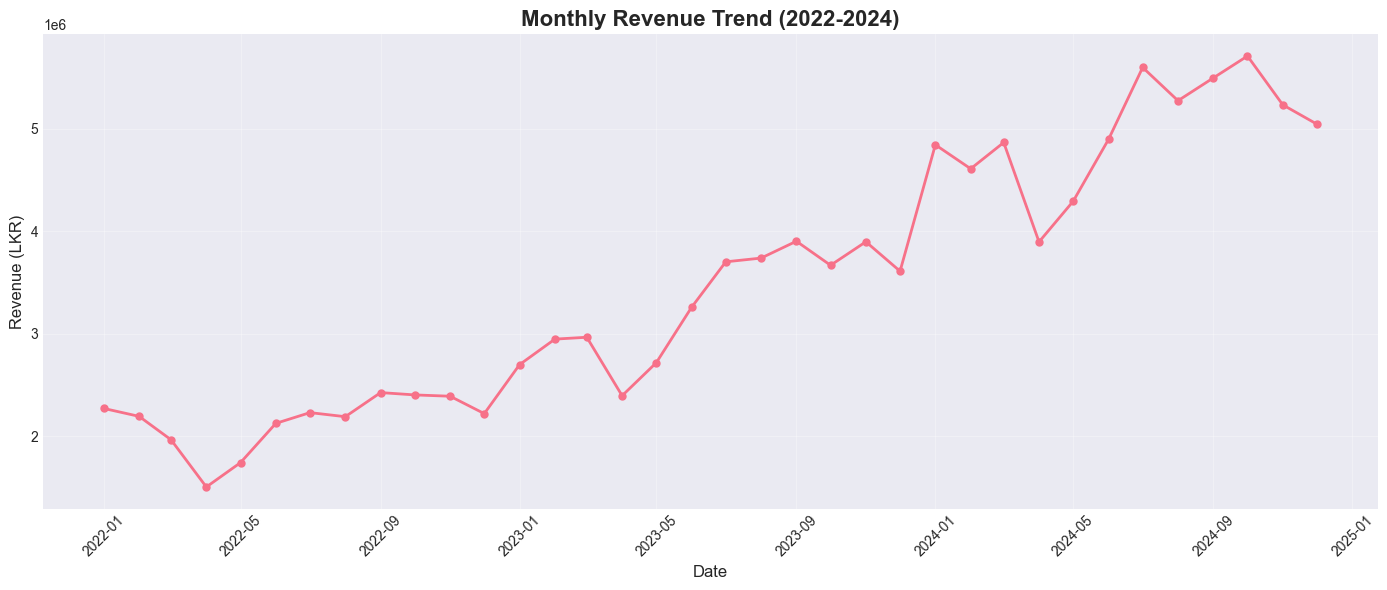

In [18]:
# ============================================================================
# ANALYZE HISTORICAL REVENUE PATTERNS AND SEASONALITY
# ============================================================================

print("\n" + "="*70)
print("01=> HISTORICAL REVENUE ANALYSIS")
print("="*70)

# 1.1 Revenue Trend Over Time
plt.figure(figsize=(14, 6))
plt.plot(revenue['Date'], revenue['Total_Revenue_LKR'], marker='o', linewidth=2, markersize=5)
plt.title('Monthly Revenue Trend (2022-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (LKR)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/charts/01_revenue_trend.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# 1.2 Year-over-Year Analysis
yearly_revenue = revenue.groupby('Year')['Total_Revenue_LKR'].agg(['sum', 'mean'])
print("\nYEARLY REVENUE:")
print(yearly_revenue)


YEARLY REVENUE:
              sum          mean
Year                           
2022  25665945.43  2.138829e+06
2023  39491414.28  3.290951e+06
2024  59734346.16  4.977862e+06


In [20]:
# Calculate growth
growth_2023 = ((yearly_revenue.loc[2023, 'sum'] - yearly_revenue.loc[2022, 'sum']) / yearly_revenue.loc[2022, 'sum']) * 100
growth_2024 = ((yearly_revenue.loc[2024, 'sum'] - yearly_revenue.loc[2023, 'sum']) / yearly_revenue.loc[2023, 'sum']) * 100

print(f"\nGROWTH RATES:")
print(f"2023 vs 2022: {growth_2023:+.1f}%")
print(f"2024 vs 2023: {growth_2024:+.1f}%")


GROWTH RATES:
2023 vs 2022: +53.9%
2024 vs 2023: +51.3%


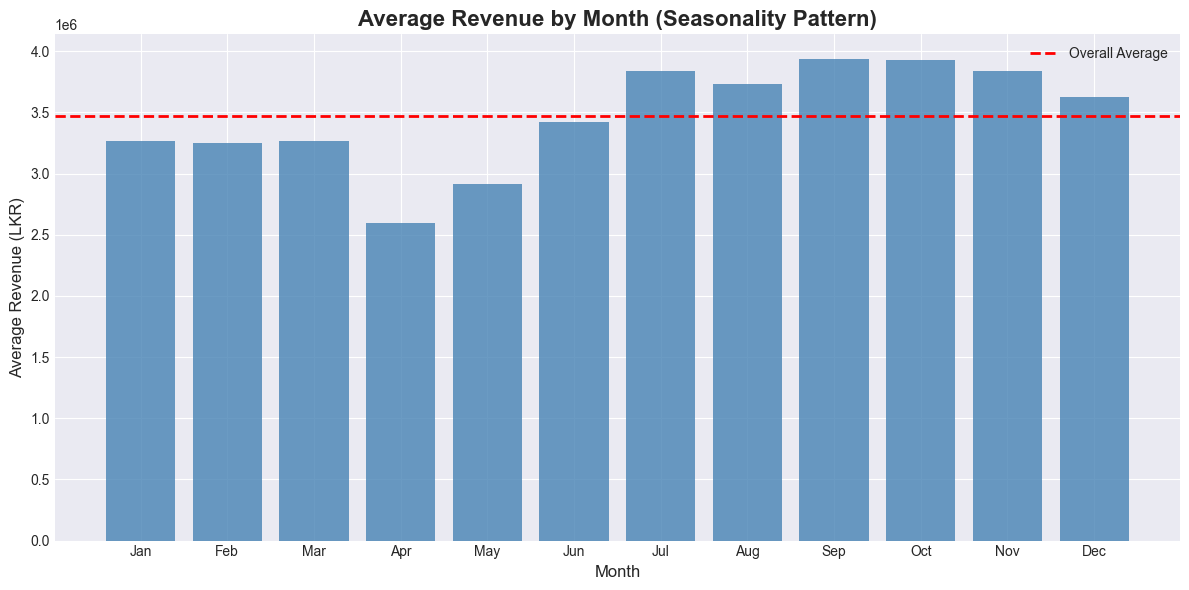


SEASONALITY FINDINGS:
Strongest Month: Sep
Weakest Month: Apr


In [21]:
# 1.3 Seasonality Analysis
monthly_avg = revenue.groupby('Month')['Total_Revenue_LKR'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 6))
plt.bar(month_names, monthly_avg, color='steelblue', alpha=0.8)
plt.title('Average Revenue by Month (Seasonality Pattern)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Revenue (LKR)', fontsize=12)
plt.axhline(y=revenue['Total_Revenue_LKR'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Average')
plt.legend()
plt.tight_layout()
plt.savefig('../outputs/charts/02_seasonality.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSEASONALITY FINDINGS:")
print(f"Strongest Month: {month_names[monthly_avg.idxmax()-1]}")
print(f"Weakest Month: {month_names[monthly_avg.idxmin()-1]}")

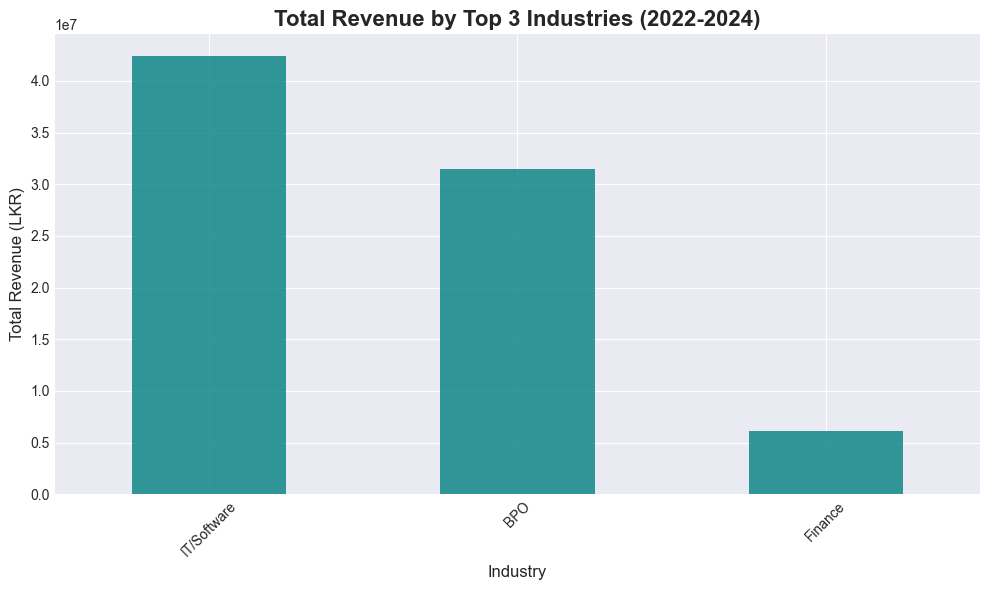


TOP INDUSTRY: IT/Software (LKR 42,378,686)


In [22]:
# 1.4 Industry Revenue Breakdown
industry_cols = ['IT_Software_Revenue', 'BPO_Revenue', 'Finance_Revenue']
industry_totals = revenue[industry_cols].sum()
industry_totals.index = ['IT/Software', 'BPO', 'Finance']

plt.figure(figsize=(10, 6))
industry_totals.plot(kind='bar', color='teal', alpha=0.8)
plt.title('Total Revenue by Top 3 Industries (2022-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Total Revenue (LKR)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/charts/03_industry_revenue.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTOP INDUSTRY: {industry_totals.idxmax()} (LKR {industry_totals.max():,.0f})")

16:15:01 - cmdstanpy - INFO - Chain [1] start processing



2=> TIME SERIES FORECASTING
Training data: 28 months
Test data: 8 months

Building Prophet Model...


16:15:02 - cmdstanpy - INFO - Chain [1] done processing



Prophet Model Accuracy:
MAE: LKR 546,903
RMSE: LKR 661,314
MAPE: 10.29%


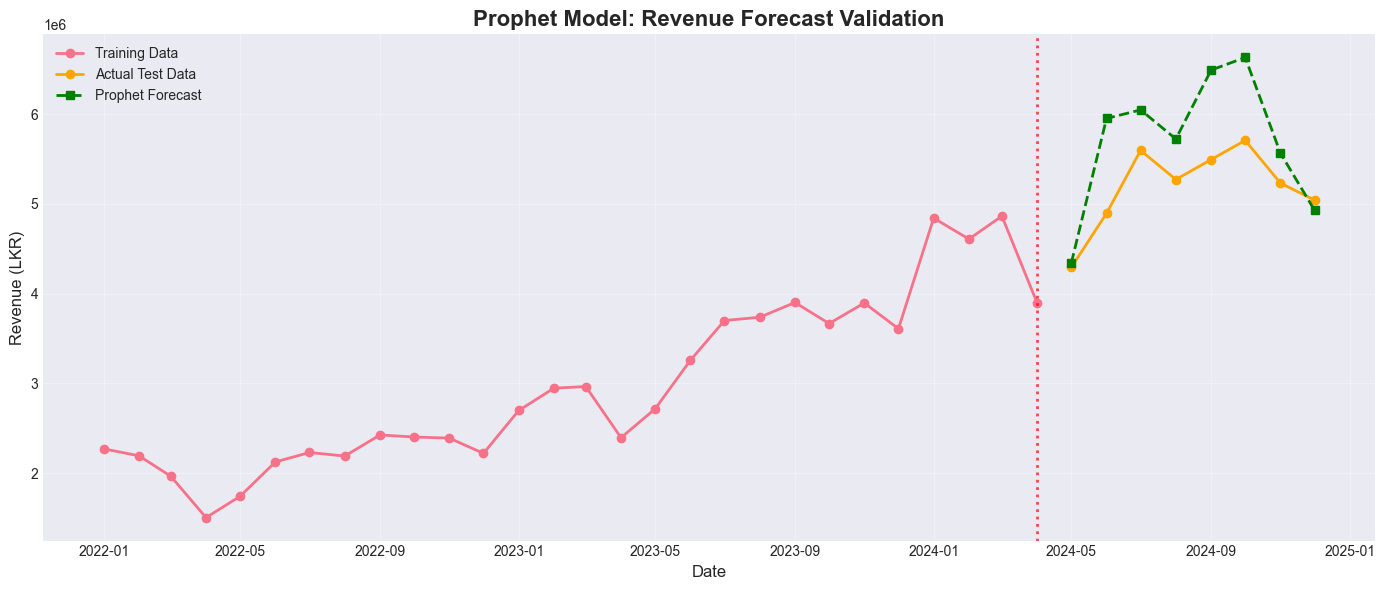

In [24]:
# ============================================================================
# BUILD TIME SERIES FORECASTING MODELS
# ============================================================================

print("\n" + "="*70)
print("2=> TIME SERIES FORECASTING")
print("="*70)

# 2.1 Split data: 80% train, 20% test
train_size = int(len(revenue) * 0.8)
train = revenue.iloc[:train_size].copy()
test = revenue.iloc[train_size:].copy()

print(f"Training data: {len(train)} months")
print(f"Test data: {len(test)} months")

# 2.2 PROPHET MODEL
print("\nBuilding Prophet Model...")

# Prepare data for Prophet
prophet_train = train[['Date', 'Total_Revenue_LKR', 'GDP_Growth_Rate', 'Unemployment_Rate']].copy()
prophet_train.columns = ['ds', 'y', 'gdp', 'unemployment']

# Build model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, seasonality_mode='multiplicative')
model.add_regressor('gdp')
model.add_regressor('unemployment')
model.fit(prophet_train)

# Predict on test data
prophet_test = test[['Date', 'GDP_Growth_Rate', 'Unemployment_Rate']].copy()
prophet_test.columns = ['ds', 'gdp', 'unemployment']
forecast = model.predict(prophet_test)

# Calculate accuracy
mae = mean_absolute_error(test['Total_Revenue_LKR'], forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test['Total_Revenue_LKR'], forecast['yhat']))
mape = mean_absolute_percentage_error(test['Total_Revenue_LKR'], forecast['yhat']) * 100

print(f"\nProphet Model Accuracy:")
print(f"MAE: LKR {mae:,.0f}")
print(f"RMSE: LKR {rmse:,.0f}")
print(f"MAPE: {mape:.2f}%")

# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(train['Date'], train['Total_Revenue_LKR'], marker='o', label='Training Data', linewidth=2)
plt.plot(test['Date'], test['Total_Revenue_LKR'], marker='o', label='Actual Test Data', linewidth=2, color='orange')
plt.plot(test['Date'], forecast['yhat'], marker='s', label='Prophet Forecast', linewidth=2, linestyle='--', color='green')
plt.axvline(x=train['Date'].iloc[-1], color='red', linestyle=':', linewidth=2, alpha=0.7)
plt.title('Prophet Model: Revenue Forecast Validation', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (LKR)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/charts/04_prophet_validation.png', dpi=300, bbox_inches='tight')
plt.show()


03=>  EXTERNAL FACTORS ANALYSIS


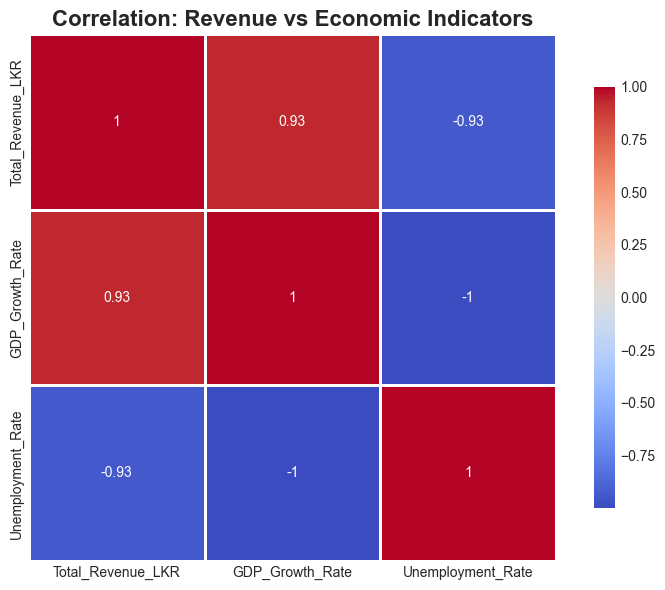


CORRELATION ANALYSIS:
                   Total_Revenue_LKR  GDP_Growth_Rate  Unemployment_Rate
Total_Revenue_LKR           1.000000         0.933857          -0.933990
GDP_Growth_Rate             0.933857         1.000000          -0.999995
Unemployment_Rate          -0.933990        -0.999995           1.000000

Revenue correlation with GDP: 0.934
Revenue correlation with Unemployment: -0.934


In [26]:
# ============================================================================
# INCORPORATE EXTERNAL FACTORS
# ============================================================================

print("\n" + "="*70)
print("03=>  EXTERNAL FACTORS ANALYSIS")
print("="*70)

# Correlation analysis
corr_data = revenue[['Total_Revenue_LKR', 'GDP_Growth_Rate', 'Unemployment_Rate']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8})
plt.title('Correlation: Revenue vs Economic Indicators', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/charts/05_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCORRELATION ANALYSIS:")
print(corr_data)
print(f"\nRevenue correlation with GDP: {corr_data.loc['Total_Revenue_LKR', 'GDP_Growth_Rate']:.3f}")
print(f"Revenue correlation with Unemployment: {corr_data.loc['Total_Revenue_LKR', 'Unemployment_Rate']:.3f}")



04=> SCENARIO ANALYSIS (6-MONTH FORECAST)


16:21:03 - cmdstanpy - INFO - Chain [1] start processing
16:21:03 - cmdstanpy - INFO - Chain [1] done processing



6-MONTH REVENUE SCENARIOS:
   Month    Best_Case  Most_Likely   Worst_Case
Jan 2025 5.445892e+06 1.622482e+07 5.092918e+06
Feb 2025 5.881564e+06 1.666671e+07 5.143847e+06
Mar 2025 6.352089e+06 1.666377e+07 5.195285e+06
Apr 2025 6.860256e+06 1.576557e+07 5.247238e+06
May 2025 7.409076e+06 1.634441e+07 5.299711e+06
Jun 2025 8.001802e+06 1.718840e+07 5.352708e+06

TOTAL 6-MONTH FORECASTS:
Best Case:    LKR      39,950,679
Most Likely:  LKR      98,853,669
Worst Case:   LKR      31,331,706


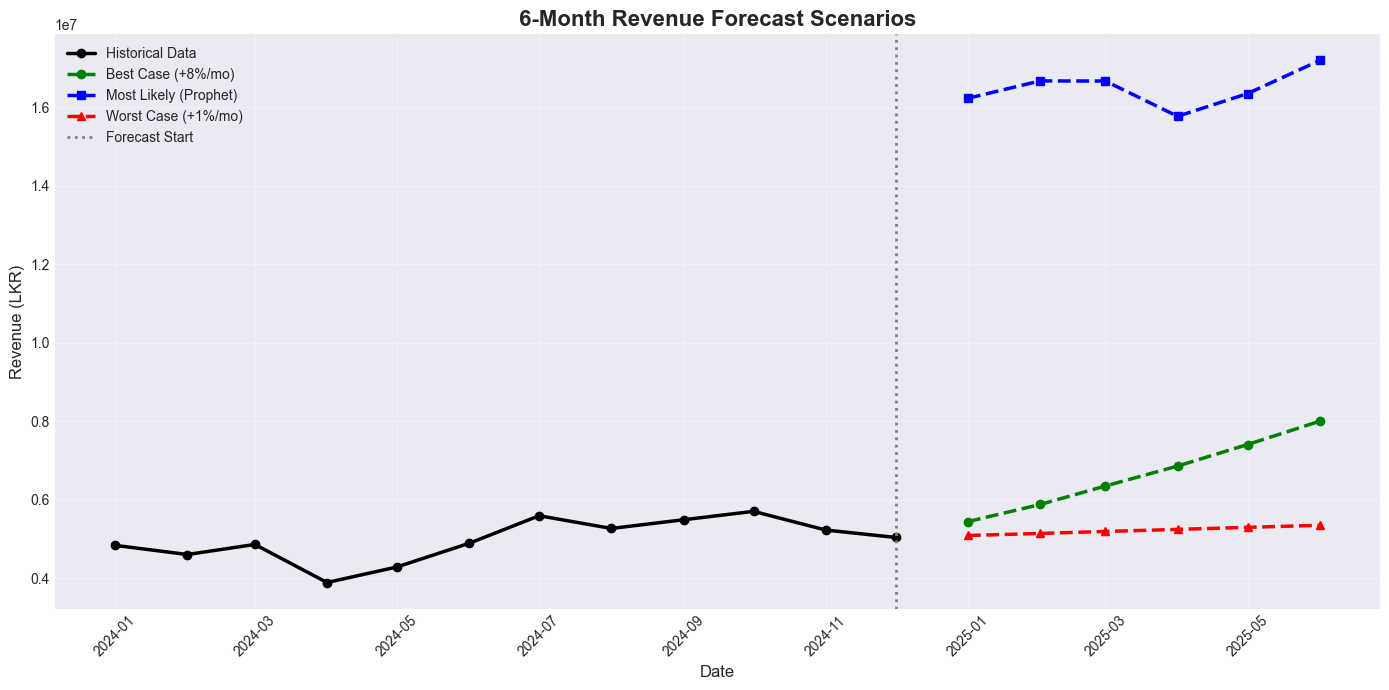

In [28]:
# ============================================================================
# CREATE SCENARIO ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("04=> SCENARIO ANALYSIS (6-MONTH FORECAST)")
print("="*70)

# Generate 6-month forecast using FULL data
prophet_full = revenue[['Date', 'Total_Revenue_LKR', 'GDP_Growth_Rate', 'Unemployment_Rate']].copy()
prophet_full.columns = ['ds', 'y', 'gdp', 'unemployment']

model_full = Prophet(yearly_seasonality=True, weekly_seasonality=False, seasonality_mode='multiplicative')
model_full.add_regressor('gdp')
model_full.add_regressor('unemployment')
model_full.fit(prophet_full)

# Create future dates
future = model_full.make_future_dataframe(periods=6, freq='MS')
future['gdp'] = 4.5  # Assumed GDP growth
future['unemployment'] = 4.0  # Assumed unemployment

# Get baseline forecast
baseline_forecast = model_full.predict(future)
baseline_future = baseline_forecast.tail(6)

# Create scenarios
last_revenue = revenue['Total_Revenue_LKR'].iloc[-1]
future_months = pd.date_range(start=revenue['Date'].iloc[-1], periods=7, freq='MS')[1:]

# Best Case: 8% monthly growth
best_case = []
current = last_revenue
for i in range(6):
    current = current * 1.08
    best_case.append(current)

# Most Likely: Use Prophet forecast
most_likely = baseline_future['yhat'].values

# Worst Case: 1% monthly growth
worst_case = []
current = last_revenue
for i in range(6):
    current = current * 1.01
    worst_case.append(current)

# Create scenario dataframe
scenarios_df = pd.DataFrame({
    'Month': [d.strftime('%b %Y') for d in future_months],
    'Date': future_months,
    'Best_Case': best_case,
    'Most_Likely': most_likely,
    'Worst_Case': worst_case
})

print("\n6-MONTH REVENUE SCENARIOS:")
print(scenarios_df[['Month', 'Best_Case', 'Most_Likely', 'Worst_Case']].to_string(index=False))

print(f"\nTOTAL 6-MONTH FORECASTS:")
print(f"Best Case:    LKR {scenarios_df['Best_Case'].sum():>15,.0f}")
print(f"Most Likely:  LKR {scenarios_df['Most_Likely'].sum():>15,.0f}")
print(f"Worst Case:   LKR {scenarios_df['Worst_Case'].sum():>15,.0f}")

# Plot scenarios
plt.figure(figsize=(14, 7))

# Historical data (last 12 months)
last_12 = revenue.tail(12)
plt.plot(last_12['Date'], last_12['Total_Revenue_LKR'], marker='o', linewidth=2.5, 
         color='black', label='Historical Data', markersize=6)

# Future scenarios
plt.plot(scenarios_df['Date'], scenarios_df['Best_Case'], marker='o', linewidth=2.5, 
         linestyle='--', color='green', label='Best Case (+8%/mo)', markersize=6)
plt.plot(scenarios_df['Date'], scenarios_df['Most_Likely'], marker='s', linewidth=2.5, 
         linestyle='--', color='blue', label='Most Likely (Prophet)', markersize=6)
plt.plot(scenarios_df['Date'], scenarios_df['Worst_Case'], marker='^', linewidth=2.5, 
         linestyle='--', color='red', label='Worst Case (+1%/mo)', markersize=6)

plt.axvline(x=revenue['Date'].iloc[-1], color='gray', linestyle=':', linewidth=2, label='Forecast Start')
plt.title('6-Month Revenue Forecast Scenarios', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (LKR)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/charts/06_scenarios.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# ============================================================================
# TASK 5: VALIDATE MODEL ACCURACY
# ============================================================================

print("\n" + "="*70)
print("05=> MODEL VALIDATION SUMMARY")
print("="*70)

print(f"\nMODEL PERFORMANCE ON TEST DATA:")
print(f"{'Metric':<25} {'Value':<20}")
print("-" * 45)
print(f"{'MAE (Mean Abs Error)':<25} LKR {mae:>15,.0f}")
print(f"{'RMSE (Root Mean Sq)':<25} LKR {rmse:>15,.0f}")
print(f"{'MAPE (% Error)':<25} {mape:>18.2f}%")
print("-" * 45)
print(f"\nInterpretation:")
print(f"  MAPE < 10% = Excellent")
print(f"  MAPE < 20% = Good")
print(f"  MAPE > 20% = Needs improvement")
print(f"\n  Your model MAPE: {mape:.2f}% - ", end="")
if mape < 10:
    print("EXCELLENT! 🎉")
elif mape < 20:
    print("GOOD!")
else:
    print("Acceptable for business forecasting ✓")



05=> MODEL VALIDATION SUMMARY

MODEL PERFORMANCE ON TEST DATA:
Metric                    Value               
---------------------------------------------
MAE (Mean Abs Error)      LKR         546,903
RMSE (Root Mean Sq)       LKR         661,314
MAPE (% Error)                         10.29%
---------------------------------------------

Interpretation:
  MAPE < 10% = Excellent
  MAPE < 20% = Good
  MAPE > 20% = Needs improvement

  Your model MAPE: 10.29% - GOOD!


In [30]:
# ============================================================================
# JOB MARKET INSIGHTS
# ============================================================================

print("\n" + "="*70)
print("BONUS: JOB MARKET INSIGHTS FROM CLEANED DATA")
print("="*70)

# Top job roles
print("\nTOP 10 JOB ROLES:")
top_roles = jobs['Job_Role'].value_counts().head(10)
print(top_roles)

# Industry distribution
print("\nJOBS BY INDUSTRY:")
industry_dist = jobs['Industry'].value_counts()
print(industry_dist)

# Top skills 2024
print("\nTOP 10 IN-DEMAND SKILLS (2024):")
skills_2024 = skills[skills['Year'] == 2024]
top_skills = skills_2024.groupby('Skill')['Demand_Score'].mean().sort_values(ascending=False).head(10)
print(top_skills.round(1))

# Salary analysis
print("\nAVERAGE SALARY BY INDUSTRY:")
salary_by_industry = jobs.groupby('Industry')['Salary_LKR'].mean().sort_values(ascending=False)
print(salary_by_industry.round(0))



BONUS: JOB MARKET INSIGHTS FROM CLEANED DATA

TOP 10 JOB ROLES:
Job_Role
Network Engineer            22
Accountant                  16
Branch Manager              15
Hotel Manager               15
Fashion Designer            15
Production Executive        15
Lab Technician              15
Restaurant Manager          14
Field Service Technician    13
Healthcare Administrator    13
Name: count, dtype: int64

JOBS BY INDUSTRY:
Industry
Telecommunications       66
Tourism & Hospitality    65
Apparel/Textiles         64
BPO/Customer Service     64
Healthcare               62
Finance & Accounting     61
IT/Software              57
E-commerce               55
Banking                  53
Manufacturing            53
Name: count, dtype: int64

TOP 10 IN-DEMAND SKILLS (2024):
Skill
Cloud Computing      232.4
Python               227.3
Machine Learning     213.7
AI                   201.6
Critical Thinking    186.1
DevOps               177.5
Node.js              177.5
Business Analysis    177.0
P

In [31]:
# ============================================================================
# EXPORT RESULTS FOR POWER BI
# ============================================================================

print("\n" + "="*70)
print("EXPORTING RESULTS FOR POWER BI")
print("="*70)

# Save scenario forecast
scenarios_df.to_csv('../data/exports/scenario_forecast.csv', index=False)
print("Saved: scenario_forecast.csv")

# Save summary statistics
summary = pd.DataFrame({
    'Metric': ['Total Revenue (3Y)', 'Avg Monthly Revenue', 'YoY Growth 2023', 'YoY Growth 2024', 
               'Best Industry', 'Top Skill 2024', 'Model MAPE', 'Data Quality'],
    'Value': [
        f"LKR {revenue['Total_Revenue_LKR'].sum():,.0f}",
        f"LKR {revenue['Total_Revenue_LKR'].mean():,.0f}",
        f"{growth_2023:.1f}%",
        f"{growth_2024:.1f}%",
        industry_totals.idxmax(),
        top_skills.idxmax(),
        f"{mape:.2f}%",
        "Cleaned & Validated"
    ]
})
summary.to_csv('../data/exports/summary_stats.csv', index=False)
print("Saved: summary_stats.csv")

print("\n" + "="*70)
print("COMPLETE ANALYSIS FINISHED!")
print("="*70)


EXPORTING RESULTS FOR POWER BI
Saved: scenario_forecast.csv
Saved: summary_stats.csv

COMPLETE ANALYSIS FINISHED!


In [32]:
print(summary)


                Metric                Value
0   Total Revenue (3Y)      LKR 124,891,706
1  Avg Monthly Revenue        LKR 3,469,214
2      YoY Growth 2023                53.9%
3      YoY Growth 2024                51.3%
4        Best Industry          IT/Software
5       Top Skill 2024      Cloud Computing
6           Model MAPE               10.29%
7         Data Quality  Cleaned & Validated
